In [145]:
# This program allows us to analyze intervallic characteristics
# such as harmonics, consonance, interference, spectrum composition, etc.
# Nick Porter

import math
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from fractions import Fraction

In [171]:
# define pitches
note = ["C","Db","D","Eb","E","F","Gb","G","Ab","A","Bb","B"]
# init vars
octave = 0
count = 0
notes = []

# 8 octaves of note names in format: note# octave
# ex. A4 is A in the 4th octave
for number in range(108):
    notes.append("%s%d" %(note[number % 12], octave))
    count = count+1
    if count == 12:
        octave = octave+1
        count = 0
        
# 8 octaves of pitches matched with note names
A4 = 440     # A440 pitch standard 440 Hz
pitch = {}
for k in range(108):
    pitch[notes[k]] = A4 * (2**(1/12))**(k-57)
# above pitch equation:
# all notes relative to standard A440 pitch
# frequency of a pitch relative to standard is:
# ratio = (2^(1/12))^n
# where n is the # of half-steps from the standard to the pitch
# n = k-57 such that n=0 corresponds to A440 with 108 pitches

In [172]:
# indexing and dimension definitions
pi = np.pi

T = 1000       # duration of input signal (T samples)
k = 8          # N to the kth power
N = 2**k       # desired length of zero padded input signal for an N-point FFT
# make sure N is sufficiently larger than T
while T*2 > N:
    k = k + 1
    N = 2**k

fs = 22050       # sampling freq
Ts = 1/fs        # delta t
ws = 2*np.pi*fs  # sampling freq (rad)

# zero pad
C = int((N-T)/2)        # index at t = 0
D = C + T               # index at t = T
n = np.linspace(0,T,T)
n_pad = np.linspace(0,N,N)


In [173]:
# Part I: combination and harmonics

# frequency for input sines
# Hz
fa = pitch['A4']
fb = pitch['Db5']
# rads
wa = 2*pi*fa
wb = 2*pi*fb

# define input signal

# sinusoid sum
sinx = np.zeros(N)
sin_wa = np.sin(wa*Ts*n)
sin_wb = np.sin(wb*Ts*n)
sinx[C:D] = sin_wa + sin_wb
sinx_title = 'sum of sinusoids'

# all harmonic sinusoid
num_harm = 11             # number of harmonics to include
sin_h = np.zeros(N)
sig = np.zeros(T)
for m in range(num_harm):
    harm = (1/(1+m))*np.sin(wa*(1+m)*Ts*n)
    sig = sig + harm
sin_h[C:D] = sig
sinh_title = 'sum of harmonics'

# odd harmonic sinusoid
sin_o = np.zeros(N)
sig = np.zeros(T)
for m in range(num_harm):
    odd = 2+(2*m-1)
    harm = (1/odd)*np.sin(wa*odd*Ts*n)
    sig = sig + harm
sin_o[C:D] = sig
sino_title = 'sum of odd harmonics'

# even harmonic sinusoid
sin_e = np.zeros(N)
sig = np.zeros(T)
for m in range(num_harm):
    even = 2*(m+1)
    harm = (2/even)*np.sin(wa*even*Ts*n)
    sig = sig + harm
sin_e[C:D] = sig
sine_title = 'sum of even harmonics'

# choose which input signal to analyze
#x = sinx
#sig_title = sinx_title
#x = sin_h
#sig_title = sinh_title
x = sin_o
sig_title = sino_title
#x = sin_e
#sig_title = sine_title


Text(0, 0.5, 'magnitude')

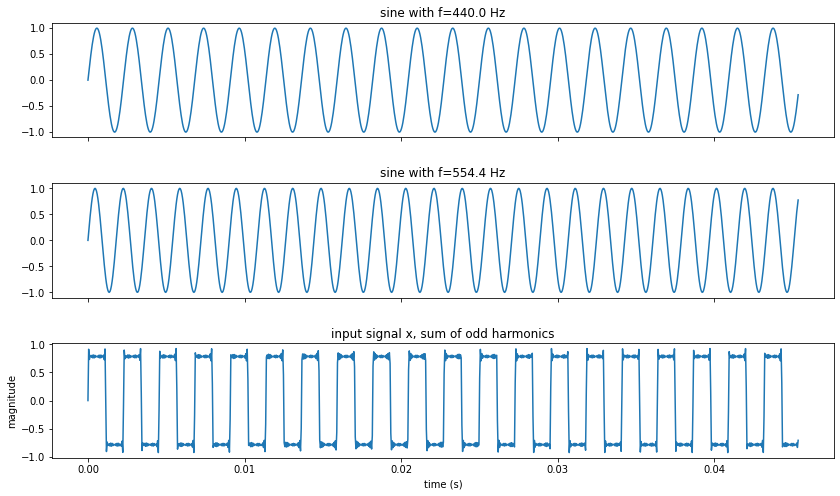

In [174]:
# plot harmonics
t = np.linspace(0,Ts*T,T)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14,8), sharex=True)
plt.subplots_adjust(hspace=.4)      # leave space between subplots

ax1.plot(t,sin_wa)
ax1.set_title('sine with f=%.1f Hz' % fa)

ax2.plot(t,sin_wb)
ax2.set_title('sine with f=%.1f Hz' % fb)

ax3.plot(t,x[C:D])
ax3.set_title('input signal x, %s' % sig_title)
ax3.set_xlabel('time (s)')
ax3.set_ylabel('magnitude')

In [178]:
# Part II: interval combination

# define major 3rd
# Hz
fa = pitch['A4']
fb = pitch['Db5']
# rads
wa = 2*pi*fa
wb = 2*pi*fb

maj3 = np.zeros(N)
sin_wa = np.sin(wa*Ts*n)
sin_wb = np.sin(wb*Ts*n)
maj3[C:D] = sin_wa + sin_wb
maj3_title = 'major 3rd: %.1f to %.1f' %(fa,fb)

# define minor 3rd
# Hz
fa = pitch['A4']
fb = pitch['C5']
# rads
wa = 2*pi*fa
wb = 2*pi*fb

min3 = np.zeros(N)
sin_wa = np.sin(wa*Ts*n)
sin_wb = np.sin(wb*Ts*n)
min3[C:D] = sin_wa + sin_wb
min3_title = 'minor 3rd: %.1f to %.1f' %(fa,fb)

Text(0, 0.5, 'magnitude')

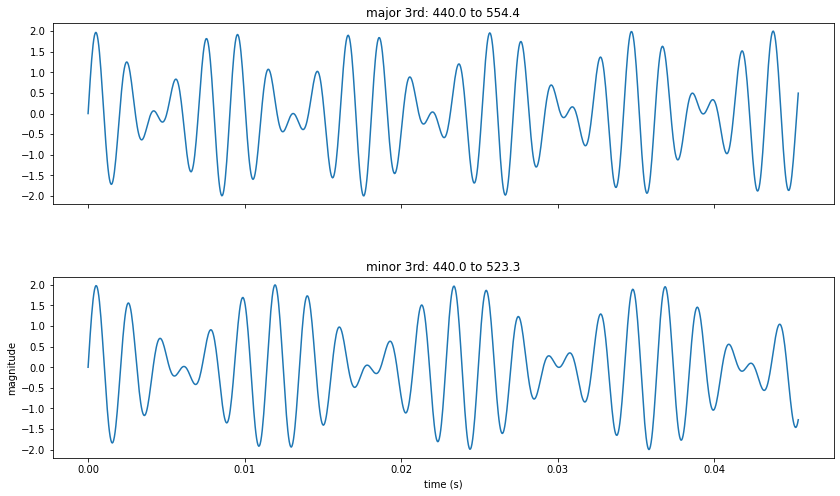

In [179]:
# plot two intervals

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,8), sharex=True)
plt.subplots_adjust(hspace=.4)      # leave space between subplots

ax1.plot(t,maj3[C:D])
ax1.set_title('%s' % maj3_title)

ax2.plot(t,min3[C:D])
ax2.set_title('%s' % min3_title)
ax2.set_xlabel('time (s)')
ax2.set_ylabel('magnitude')

In [285]:
# need functions to determine how close 
# the given interval is to a 'simple' one
# the closer to a simple ratio, the more
# consonant the interval

# get ratio info from notes
def f_to_ratio(b,a):
    b = int(b)
    a = int(a)
    div = np.gcd(b,a)
    nume = int(b/div)
    deno = int(a/div)
    rat = nume/deno
    return nume,deno,div,rat

# get closest simple ratio from numerator/denominator
# given by f_to_ratio()
def close_to_simple_ratio(nume,deno):
    pmin_diff = 1000
    closest_simple_ratio = 1
    for i in range(12):
        for j in range(11):
            diff = np.abs(nume/deno - i/(j+1))
            if diff < pmin_diff:
                pmin_diff = diff
                closest_num = i
                closest_den = (j+1)
            else:
                diff = diff
    return closest_num,closest_den,pmin_diff

# show closest simple ratios for an octave of intervals
intervals = ['unison','minor 2nd','2nd','minor 3rd','major 3rd','perfect 4th',
             'flat 5th','perfect 5th','minor 6th','major 6th','dom 7th','maj 7th','octave']
offset = 57            # index of note from notes[]
fund = notes[offset]   # notes[57] = A4
f0 = pitch[fund]
interval_ratio = {}
print('fundamental: %s' % fund)
print('')
for k in range(13):
    fb = pitch[notes[offset+k]]
    nume,deno,div,rat = f_to_ratio(fb,f0)
    c_num,c_den,diff = close_to_simple_ratio(nume,deno)
    interval_ratio[intervals[k]] = Fraction(c_num,c_den)
    # print results
    print('interval: %s, %s' % (intervals[k],notes[offset+k]))
    print('given note ratio: %d / %d = %f with gcd %d' %(nume,deno,rat,div))
    print('closest simple ratio: %d / %d' %(c_num,c_den))
    print('difference between simple ratio and actual ratio: %.5f' % diff)
    print('')

fundamental: A4

interval: unison, A4
given note ratio: 1 / 1 = 1.000000 with gcd 440
closest simple ratio: 1 / 1
difference between simple ratio and actual ratio: 0.00000

interval: minor 2nd, Bb4
given note ratio: 233 / 220 = 1.059091 with gcd 2
closest simple ratio: 11 / 10
difference between simple ratio and actual ratio: 0.04091

interval: 2nd, B4
given note ratio: 493 / 440 = 1.120455 with gcd 1
closest simple ratio: 9 / 8
difference between simple ratio and actual ratio: 0.00455

interval: minor 3rd, C5
given note ratio: 523 / 440 = 1.188636 with gcd 1
closest simple ratio: 6 / 5
difference between simple ratio and actual ratio: 0.01136

interval: major 3rd, Db5
given note ratio: 277 / 220 = 1.259091 with gcd 2
closest simple ratio: 5 / 4
difference between simple ratio and actual ratio: 0.00909

interval: perfect 4th, D5
given note ratio: 587 / 440 = 1.334091 with gcd 1
closest simple ratio: 4 / 3
difference between simple ratio and actual ratio: 0.00076

interval: flat 5th, Eb

In [284]:
# order the notes according to consonance
# given 12 tones per octave tuning

numden_sum = []
consonance = {}
count = 0

# sum each num+den and print ratio info
for k in range(len(intervals)):
    print('interval: ' + str(intervals[k]) + ', ratio: ' + str(interval_ratio[intervals[k]]))
    numden_sum.append(interval_ratio[intervals[k]].numerator + interval_ratio[intervals[k]].denominator)
    #print('sum of simple ratio num + den: %d' % numden_sum[k])

# sort list of indices by sum of num+den, ascending
sorted_indices = np.argsort(numden_sum)

# create dictionary to store intervals in descending order of consonance
for p in range(len(intervals)):
    consonance[intervals[sorted_indices[p]]] = interval_ratio[intervals[sorted_indices[p]]]

interval: unison, ratio: 1
interval: minor 2nd, ratio: 11/10
interval: 2nd, ratio: 9/8
interval: minor 3rd, ratio: 6/5
interval: major 3rd, ratio: 5/4
interval: perfect 4th, ratio: 4/3
interval: flat 5th, ratio: 7/5
interval: perfect 5th, ratio: 3/2
interval: minor 6th, ratio: 8/5
interval: major 6th, ratio: 5/3
interval: dom 7th, ratio: 9/5
interval: maj 7th, ratio: 11/6
interval: octave, ratio: 2


In [283]:
consonance

{'unison': Fraction(1, 1),
 'octave': Fraction(2, 1),
 'perfect 5th': Fraction(3, 2),
 'perfect 4th': Fraction(4, 3),
 'major 6th': Fraction(5, 3),
 'major 3rd': Fraction(5, 4),
 'minor 3rd': Fraction(6, 5),
 'flat 5th': Fraction(7, 5),
 'minor 6th': Fraction(8, 5),
 'dom 7th': Fraction(9, 5),
 '2nd': Fraction(9, 8),
 'maj 7th': Fraction(11, 6),
 'minor 2nd': Fraction(11, 10)}

In [181]:
# Part III: spectrum

# Power spectral density
ff, PSD = signal.periodogram(x[2:N], fs)

# mov avg fft
M = 7
cumsum, moving_aves = [0], []
for i, x in enumerate(PSD, 1):
    cumsum.append(cumsum[i-1] + x)
    if i>=M:
        moving_ave = (cumsum[i] - cumsum[i-M])/M
        moving_aves.append(moving_ave)
y = moving_aves


In [182]:
# find peaks
# broken
h_index = []
count = 0
for p in range(len(y)):
    if y[p] > 10**(-4):
        if count == 0:
            h_index.append(p)
            count = count +1
        elif count > 1:
            if p - 1 != h_index[p-1]:
                h_index.append(p)

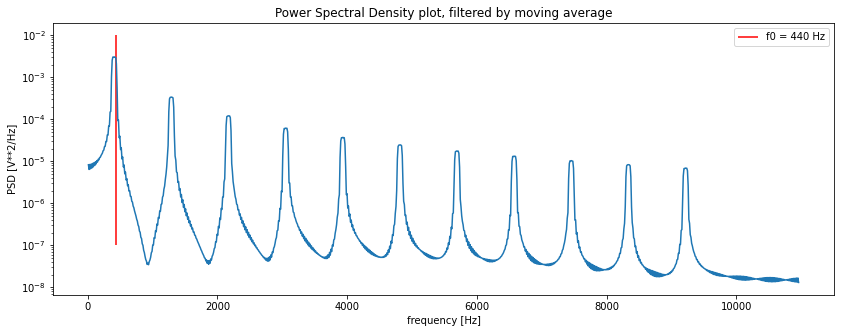

In [183]:
# plot fft
fig= plt.figure(figsize=(14,5))
plt.semilogy(ff[1:len(ff)-(M-1)], y[1:len(y)])
#plt.semilogy(ff[1:len(ff)], PSD[1:len(PSD)])
plt.title('Power Spectral Density plot, filtered by moving average')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.vlines(fa,10**-7,10**-2,colors='r',label='f0 = %d Hz' %(fa))
plt.legend()
plt.show()

Text(0, 0.5, 'magnitude')

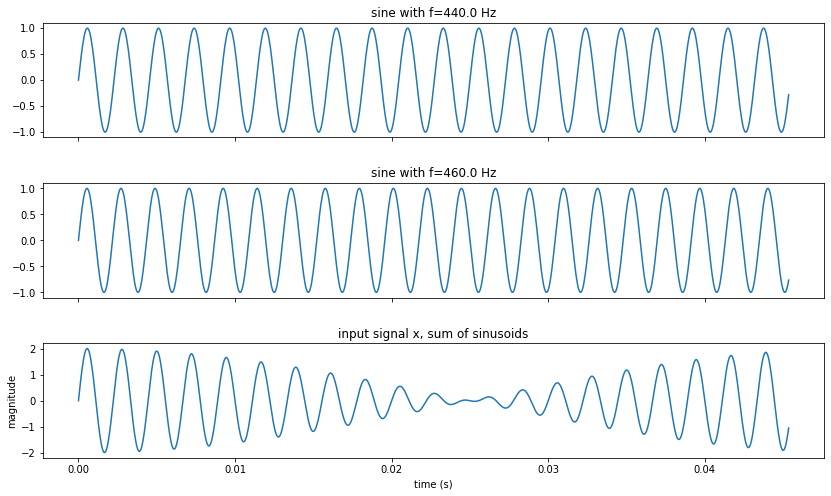

In [185]:
# Part IV: close beat frequencies

# frequency for input sines
# Hz
p_diff = 20       # 10 Hz pitch difference
fa = pitch['A4']
fb = fa + p_diff
# rads
wa = 2*pi*fa
wb = 2*pi*fb

# define input signal
# sinusoid
sinx = np.zeros(N)
sin_wa = np.sin(wa*Ts*n)
sin_wb = np.sin(wb*Ts*n)
sinx[C:D] = sin_wa + sin_wb
sinx_title = 'sum of sinusoids'

# choose which input signal to analyze
x = sinx
sig_title = sinx_title

# plot input signal
t = np.linspace(0,Ts*T,T)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14,8), sharex=True)
plt.subplots_adjust(hspace=.4)      # leave space between subplots

ax1.plot(t,sin_wa)
ax1.set_title('sine with f=%.1f Hz' % fa)

ax2.plot(t,sin_wb)
ax2.set_title('sine with f=%.1f Hz' % fb)

ax3.plot(t,x[C:D])
ax3.set_title('input signal x, %s' % sig_title)
ax3.set_xlabel('time (s)')
ax3.set_ylabel('magnitude')

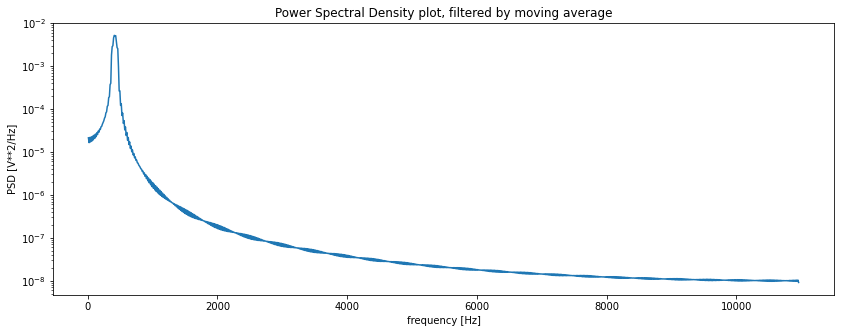

In [186]:
# Power spectral density

ff, PSD = signal.periodogram(x[2:N], fs)
fig= plt.figure(figsize=(14,5))

# mov avg fft
M = 7
cumsum, moving_aves = [0], []
for i, k in enumerate(PSD, 1):
    cumsum.append(cumsum[i-1] + k)
    if i>=M:
        moving_ave = (cumsum[i] - cumsum[i-M])/M
        moving_aves.append(moving_ave)

plt.semilogy(ff[1:len(ff)-(M-1)], moving_aves[1:len(moving_aves)])
#plt.semilogy(ff[1:len(ff)], PSD[1:len(PSD)])
plt.title('Power Spectral Density plot, filtered by moving average')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

Text(0.5, 1.0, 'impulse response')

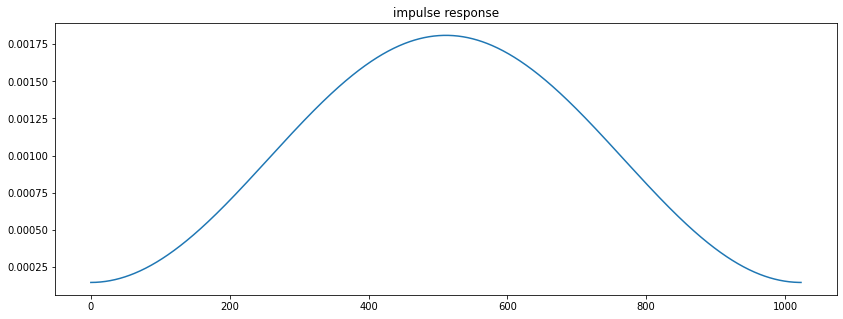

In [187]:
# Part V: filtering

# define FIR
wc1 = 0.2/(2*np.pi)       # normalized cutoff freq
L = N//2                  # length of filter window
h = signal.firwin(L,cutoff=wc1,window='hamming',pass_zero='lowpass',fs=fs)

# make non-negative (don't need for normal usage, breaks some impulse responses):
#H = scipy.fft.fft(h)
#H = np.convolve(H,H,'same')
#h = np.abs(scipy.fft.ifft(H))

# normalize:
h = h * 1/sum(h)

# plot
fig= plt.figure(figsize=(14,5))
plt.plot(range(L),h)
plt.title('impulse response')

Text(0.5, 0, 'w (0 to pi)')

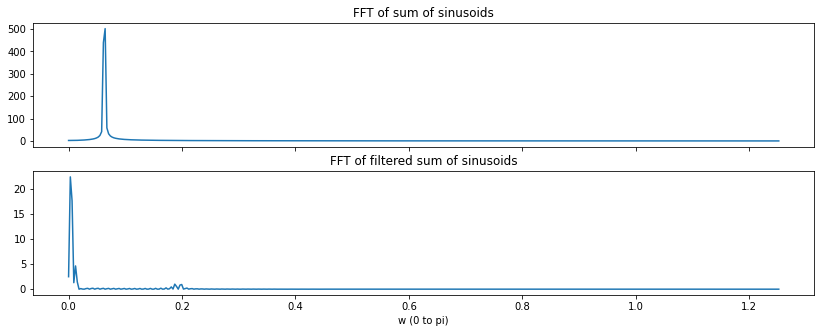

In [188]:
# apply filtering

# convolve impulse
y = np.convolve(x,h,'full')

# fft original
Y0 = np.abs(scipy.fft.fft(x[C:D]))

# fft filtered
Y1 = np.abs(scipy.fft.fft(y))

# plot
# define freq bins
w = np.linspace(0, 2*np.pi, N)
plot_len = N//5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,5), sharex=True)

#Y0_db = 20*np.log10(Y0[:plot_len])
#Y1_db = 20*np.log10(Y1[:plot_len])

ax1.plot(w[:plot_len],Y0[:plot_len])
#ax1.plot(w,Y0)
ax1.set_title('FFT of %s' % sig_title)
#ax1.set_xlabel('w (0 to pi)')
#ax1.set_ylabel('magnitude (dB)')

ax2.plot(w[:plot_len],Y1[:plot_len])
#ax2.plot(w,Y1)
ax2.set_title('FFT of filtered %s' % sig_title)
ax2.set_xlabel('w (0 to pi)')
#ax2.set_ylabel('magnitude (dB)')

In [65]:
pitch

{'C0': 16.351597831287375,
 'Db0': 17.323914436054462,
 'D0': 18.35404799483793,
 'Eb0': 19.44543648263001,
 'E0': 20.601722307054324,
 'F0': 21.826764464562697,
 'Gb0': 23.1246514194771,
 'G0': 24.49971474885928,
 'Ab0': 25.956543598746517,
 'A0': 27.499999999999947,
 'Bb0': 29.13523509488056,
 'B0': 30.867706328507698,
 'C1': 32.703195662574764,
 'Db1': 34.647828872108946,
 'D1': 36.708095989675876,
 'Eb1': 38.890872965260044,
 'E1': 41.20344461410867,
 'F1': 43.65352892912541,
 'Gb1': 46.24930283895422,
 'G1': 48.99942949771858,
 'Ab1': 51.913087197493056,
 'A1': 54.999999999999915,
 'Bb1': 58.270470189761156,
 'B1': 61.73541265701542,
 'C2': 65.40639132514957,
 'Db2': 69.29565774421793,
 'D2': 73.4161919793518,
 'Eb2': 77.78174593052012,
 'E2': 82.40688922821738,
 'F2': 87.30705785825087,
 'Gb2': 92.4986056779085,
 'G2': 97.99885899543722,
 'Ab2': 103.82617439498618,
 'A2': 109.99999999999989,
 'Bb2': 116.54094037952237,
 'B2': 123.4708253140309,
 'C3': 130.8127826502992,
 'Db3': 1